# Imports

In [1]:
import glob
import os
import struct
import time

import numpy as np
import pylab as plt
import scipy.ndimage as spImage
import sklearn.linear_model as sklLinear

%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 30.0)

# Utility

## Utility functions

In [2]:
def distort(A, scale):
  return np.clip(A + np.random.normal(scale=scale, size=A.shape), 0, 1)

In [3]:
def plot_many(shape, n_cols, *imgs):
  imgs = np.array(imgs)
  imgs = imgs.reshape(-1, *shape)
  n_imgs = imgs.shape[0]
  n_rows = (n_imgs + n_cols - 1) / n_cols

  f = plt.figure()
  for i, img in enumerate(imgs):
    row = i % n_rows
    col = i / n_rows
    f.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
    plt.imshow(-img, cmap='Greys', interpolation='none')
  plt.show()

In [4]:
def L2_squared(X):
  return np.sum(X**2)

In [5]:
def MSE(X, Y):
  return L2_squared(X - Y) / X.shape[0]

In [6]:
def normalize(X):
  X = X.T
  X -= np.min(X, axis=0)
  X /= np.max(X, axis=0)
  return X.T

In [7]:
def difference_matrix(X, Y):
  D = np.zeros((X.shape[0], Y.shape[0], Y.shape[1]))
  for i in range(X.shape[0]):
    D[i] = X[i] - Y
  return D

In [8]:
def rbf(X, Y, sigma=400):
  return np.exp(-.5 * np.sum(difference_matrix(X, Y)**2, axis=2) / sigma)

In [9]:
def drbf(X, Y, sigma=400):
  D = difference_matrix(X, Y)
  F = np.exp(-.5 * np.sum(D**2, axis=2) / sigma)
  J = -D.transpose(2, 0, 1) / sigma
  for i in range(J.shape[0]):
    J[i] *= F
  return F, J.transpose(1, 2, 0)

## Timer

In [10]:
class Timer:
  def __init__(self, msg):
    self.msg = msg
    self.interrupted = False

  def __enter__(self):
    print "Started " + self.msg
    self.t = time.time()

  def __exit__(self, type_, value_, traceback_):
    if type_ is None:
      print "Finished " + self.msg + " " + self._format(time.time() - self.t)
    else:
      print "Interrupted " + self.msg + " after " + self._format(time.time() - self.t)

  def _format(self, t):
    if t >= 60:
      m = int(t / 60)
      s = int(t - 60 * m)
      return "%dm %ds" % (m, s)
    return "%.2fs" % t


# SOAR

In [11]:
class SOAR:
  def __init__(self, kernel, alpha=1, batch_size=80, predict_epochs=300, predict_tol=1e-7, verbose=0):
    self.kernel = kernel
    self.alpha = alpha
    self.batch_size = batch_size
    self.predict_epochs = predict_epochs
    self.predict_tol = predict_tol
    self.verbose = verbose
    
  def fit(self, neutral, smiling):
    self.n, self.d = smiling.shape
    
    self.neutral = neutral
    self.smiling = smiling

    self.fit_epochs = (self.n + self.batch_size - 1) / self.batch_size
    
    if self.verbose > 0:
      print 'Training with batch_size={} in {} epochs'.format(self.batch_size, self.fit_epochs)
    
    self.a = np.zeros((self.n, self.d))
    for i in range(self.fit_epochs):
      fr = i * self.batch_size
      to = (i + 1) * self.batch_size
      neutral_idxs = neutral[fr:to]
      smiling_idxs = smiling[fr:to]
      I_n = self.alpha * np.eye(neutral_idxs.shape[0])
      self.kernel.set_x(neutral_idxs, neutral_idxs)   # (n, n)
      self.kernel.set_y(smiling_idxs, smiling_idxs)   # (n, n)
      for j in range(self.d):
        if self.verbose > 0 and j % self.verbose == 0:
          print 'Training feature {} at epoch {}'.format(j, i)
        self.a[fr:to,j] = (np.linalg.inv(self.kernel(j) + I_n)
                           .dot(smiling_idxs[:,j]))
    self.a = self.a.T
        
    return self

  def predict(self, X, Y0=None):
    Y1 = X if Y0 is None else Y0
    self.kernel.set_x(X, self.neutral)
    for _ in range(self.predict_epochs):
      self.kernel.set_y(Y1, self.smiling)
      Y2 = np.zeros(Y1.shape)
      for j in range(self.d):
        Y2[:,j] = self.kernel(j).dot(self.a[j])
      Y2 = normalize(Y2)
      d = MSE(Y1, Y2)
      if self.verbose > 0 and _ % self.verbose == 0:
        print 'Iteration #{} d={}'.format(_, d)
      if d < self.predict_tol:
        break
      Y1 = Y2
    return Y1

# Faces

## Constants

In [35]:
FACES_DIM = 9216
FACES_SHAPE = (96, 96)

NEUTRAL_FACES_GLOB = 'faces/*a*'  # Select all the neutral faces
SMILING_FACES_GLOB = 'faces/*b*'  # Select all the smiling faces

FACES_SPLIT = 150
FACES_REPEAT = 2
FACES_DISTORTION = .05

## Load Faces

In [36]:
def read_faces(faces_glob):
  faces = []
  for filename in sorted(glob.glob(faces_glob)):
    faces.append(spImage.imread(filename, flatten=True).flatten() / 255)
  return np.array(faces)

neutral = read_faces(NEUTRAL_FACES_GLOB)
smiling = read_faces(SMILING_FACES_GLOB)

p = np.random.permutation(neutral.shape[0])
neutral = neutral[p]
smiling = smiling[p]

## Split into input/output and training/testing

In [37]:
def flip_faces(faces):
  return faces.reshape(-1, *FACES_SHAPE)[:,:,::-1].reshape(-1, FACES_DIM)

neutral_training = np.append(neutral[:FACES_SPLIT], smiling[:FACES_SPLIT], axis=0)
smiling_training = np.append(smiling[:FACES_SPLIT], smiling[:FACES_SPLIT], axis=0)

neutral_training = np.append(neutral_training, flip_faces(neutral_training), axis=0)
smiling_training = np.append(smiling_training, flip_faces(smiling_training), axis=0)

if FACES_REPEAT > 1:
  neutral_training = normalize(distort(np.repeat(neutral_training, FACES_REPEAT, axis=0),
                               FACES_DISTORTION))
  smiling_training = normalize(np.repeat(smiling_training, FACES_REPEAT, axis=0))
  
neutral_test = normalize(neutral[FACES_SPLIT:])# np.append(neutral[SPLIT_1:], smiling[SPLIT_1:], axis=0)
smiling_test = normalize(smiling[FACES_SPLIT:])# np.append(smiling[SPLIT_1:], smiling[SPLIT_1:], axis=0)

## Load faces not part of the dataset

In [15]:
some_woman = spImage.imread('some_woman.jpeg', flatten=True).reshape(1, 9216) / 255
some_guy = spImage.imread('some_guy.jpeg', flatten=True).reshape(1, 9216) / 255
obama = spImage.imread('obama.jpeg', flatten=True).reshape(1, 9216) / 255
lemur_face = spImage.imread('lemur_face.jpeg', flatten=True).reshape(1, 9216) / 255
panther_face = spImage.imread('../panther.jpeg', flatten=True).reshape(1, 9216) / 255

## Add mean vector

In [16]:
class MeanRBF:
  def __init__(self, inp, out, s=40, epochs=500):
    self.rr = sklLinear.Ridge(alpha=40).fit(inp, out - inp)
    self.data = np.append(out, -inp, axis=0) / inp.shape[0]
    self.s = s
    self.epochs = epochs
  def __call__(self, X):
    _, J = drbf(X, np.append(self.data, X, axis=0), self.s)
    J = np.sum(J, axis=1).T
    J = (J / np.sqrt(np.sum(J**2, axis=0))).T
    return np.sum(_, axis=1), J
  def predict(self, X):
    X0 = Y0 = X
    lambda0 = 0
    gamma0 = 0
    for epoch in xrange(self.epochs):
      F, J = self(X0)
      if epoch % 10 == 0:
        print epoch + 1, F
      step = (epoch + 1) ** -.2
      Y1 = X0 + step * J
      lambda1 = .5 + (1 + 4 * lambda0**2)**.5 / 2
      gamma1 = (1 - lambda0) / lambda1
      X1 = (1 - gamma1) * Y1 + gamma1 * Y0
      X0 = X1
      Y0 = Y1
      
    return normalize(X0)
  
mean_rbf = MeanRBF(neutral_training, smiling_training)
with Timer("training MeanRBF"):
  pred = mean_rbf.predict(neutral_test)
      

Started training MeanRBF
1 [ 1.]
11 [ 1.]
21 [ 1.]
31 [ 1.]
41 [ 1.]
51 [ 1.00000001]
61 [ 1.00000007]
71 [ 1.00000074]
81 [ 1.00000621]
91 [ 1.00004457]
101 [ 1.00027644]
111 [ 1.001499]
121 [ 1.0071728]
131 [ 1.03052439]
141 [ 1.11629002]
151 [ 1.39888286]
161 [ 2.23796448]
171 [ 4.49160464]
181 [ 9.98416092]
191 [ 22.1626291]
201 [ 46.77788879]
211 [ 92.19329278]
221 [ 168.72913785]
231 [ 286.5060498]
241 [ 451.73716473]
251 [ 662.30260486]
261 [ 904.33631184]
271 [ 1151.84765535]
281 [ 1370.62431527]
291 [ 1525.93408805]
301 [ 1591.65724111]
311 [ 1592.82189419]
321 [ 1591.67762515]
331 [ 1592.8271031]
341 [ 1591.69638579]
351 [ 1592.83180739]
361 [ 1591.71373755]
371 [ 1592.83607884]
381 [ 1591.7298566]
391 [ 1592.83997591]
401 [ 1591.74488918]
411 [ 1592.84354676]
421 [ 1591.75895793]
431 [ 1592.84683145]
441 [ 1591.7721666]
451 [ 1592.84986359]
461 [ 1591.78460367]
471 [ 1592.85267164]
481 [ 1591.79634514]
491 [ 1592.85527981]
Finished training MeanRBF 2m 20s


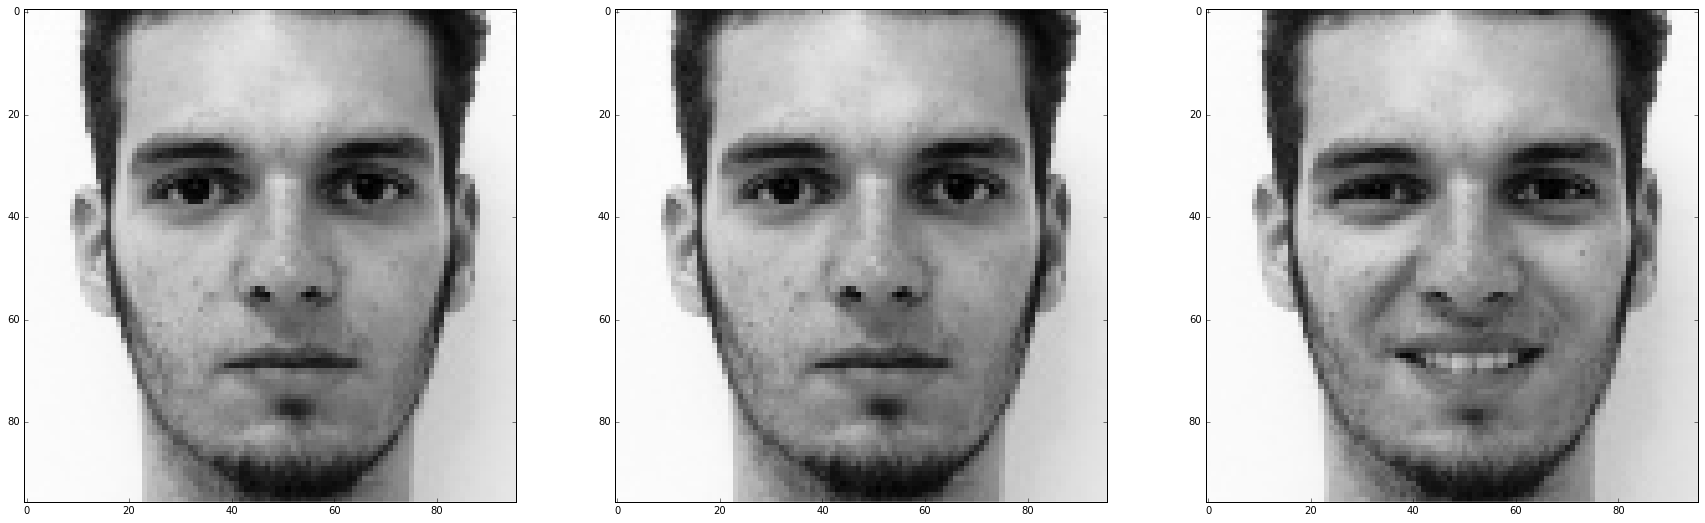

0.442756767306
39.4295057928


In [17]:
plot_many(FACES_SHAPE, 3, neutral_test[:1], pred[:5], smiling_test[:5])
print MSE(pred, neutral_test)
print MSE(pred, smiling_test)

## Selection Aware Kernel

In [39]:
std = np.std(smiling_training - neutral_training, axis=0)

std_selection = np.arange(9216)[std>.075]
rect_selection = np.arange(9216).reshape(96, 96)[45:85,25:75].flatten()

all_indices = range(9216)
indices_selected = set(std_selection).intersection(rect_selection)
indices_unselected = [i  for i in all_indices if i not in indices_selected]
indices_selected = list(indices_selected)

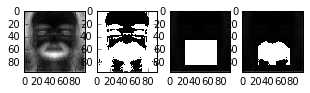

In [40]:
A = std.copy()
A[std_selection] = 2
B = std.copy()
B[rect_selection] = 2
C = std.copy()
C[indices_selected] = 2

plt.rcParams['figure.figsize'] = (5.0, 5.0)
plot_many(FACES_SHAPE, 4, std, A, B, C)
plt.rcParams['figure.figsize'] = (30.0, 30.0)

In [41]:
class SelectionAware:
  def __init__(self, selection=set(), alpha=.98):
    self.alpha = alpha
    self.selection = selection
  def set_x(self, X1, X2):
    self.X = (X1.dot(X2.T) + 1) / 50
    self.X1 = X1.T
    self.X2 = X2.T
  def set_y(self, Y1, Y2):
    self.Y = Y1.dot(Y2.T) + 1
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    r = k / 96
    c = k % 96
    ks = []
    if r > 0: ks.append(k - 96)
    if c > 0: ks.append(k - 1)
    if r < 95: ks.append(k + 96)
    if c < 95: ks.append(k + 1)
      
    Ky = self.Y1[ks].T.dot(self.Y2[ks]) + 1
    ks += [k]
    Kx = self.X1[ks].T.dot(self.X2[ks]) + 1
    
    K = Kx * Ky
    
    if k in self.selection:
      return (1 - self.alpha) * Kx * Ky + self.alpha * self.X
    return (1 - self.alpha) * Kx * Ky + self.alpha * Kx
    

Started Training Selection Aware
Finished Training Selection Aware 4m 32s
Started Training Selection Aware (w/o selection)
Finished Training Selection Aware (w/o selection) 4m 8s


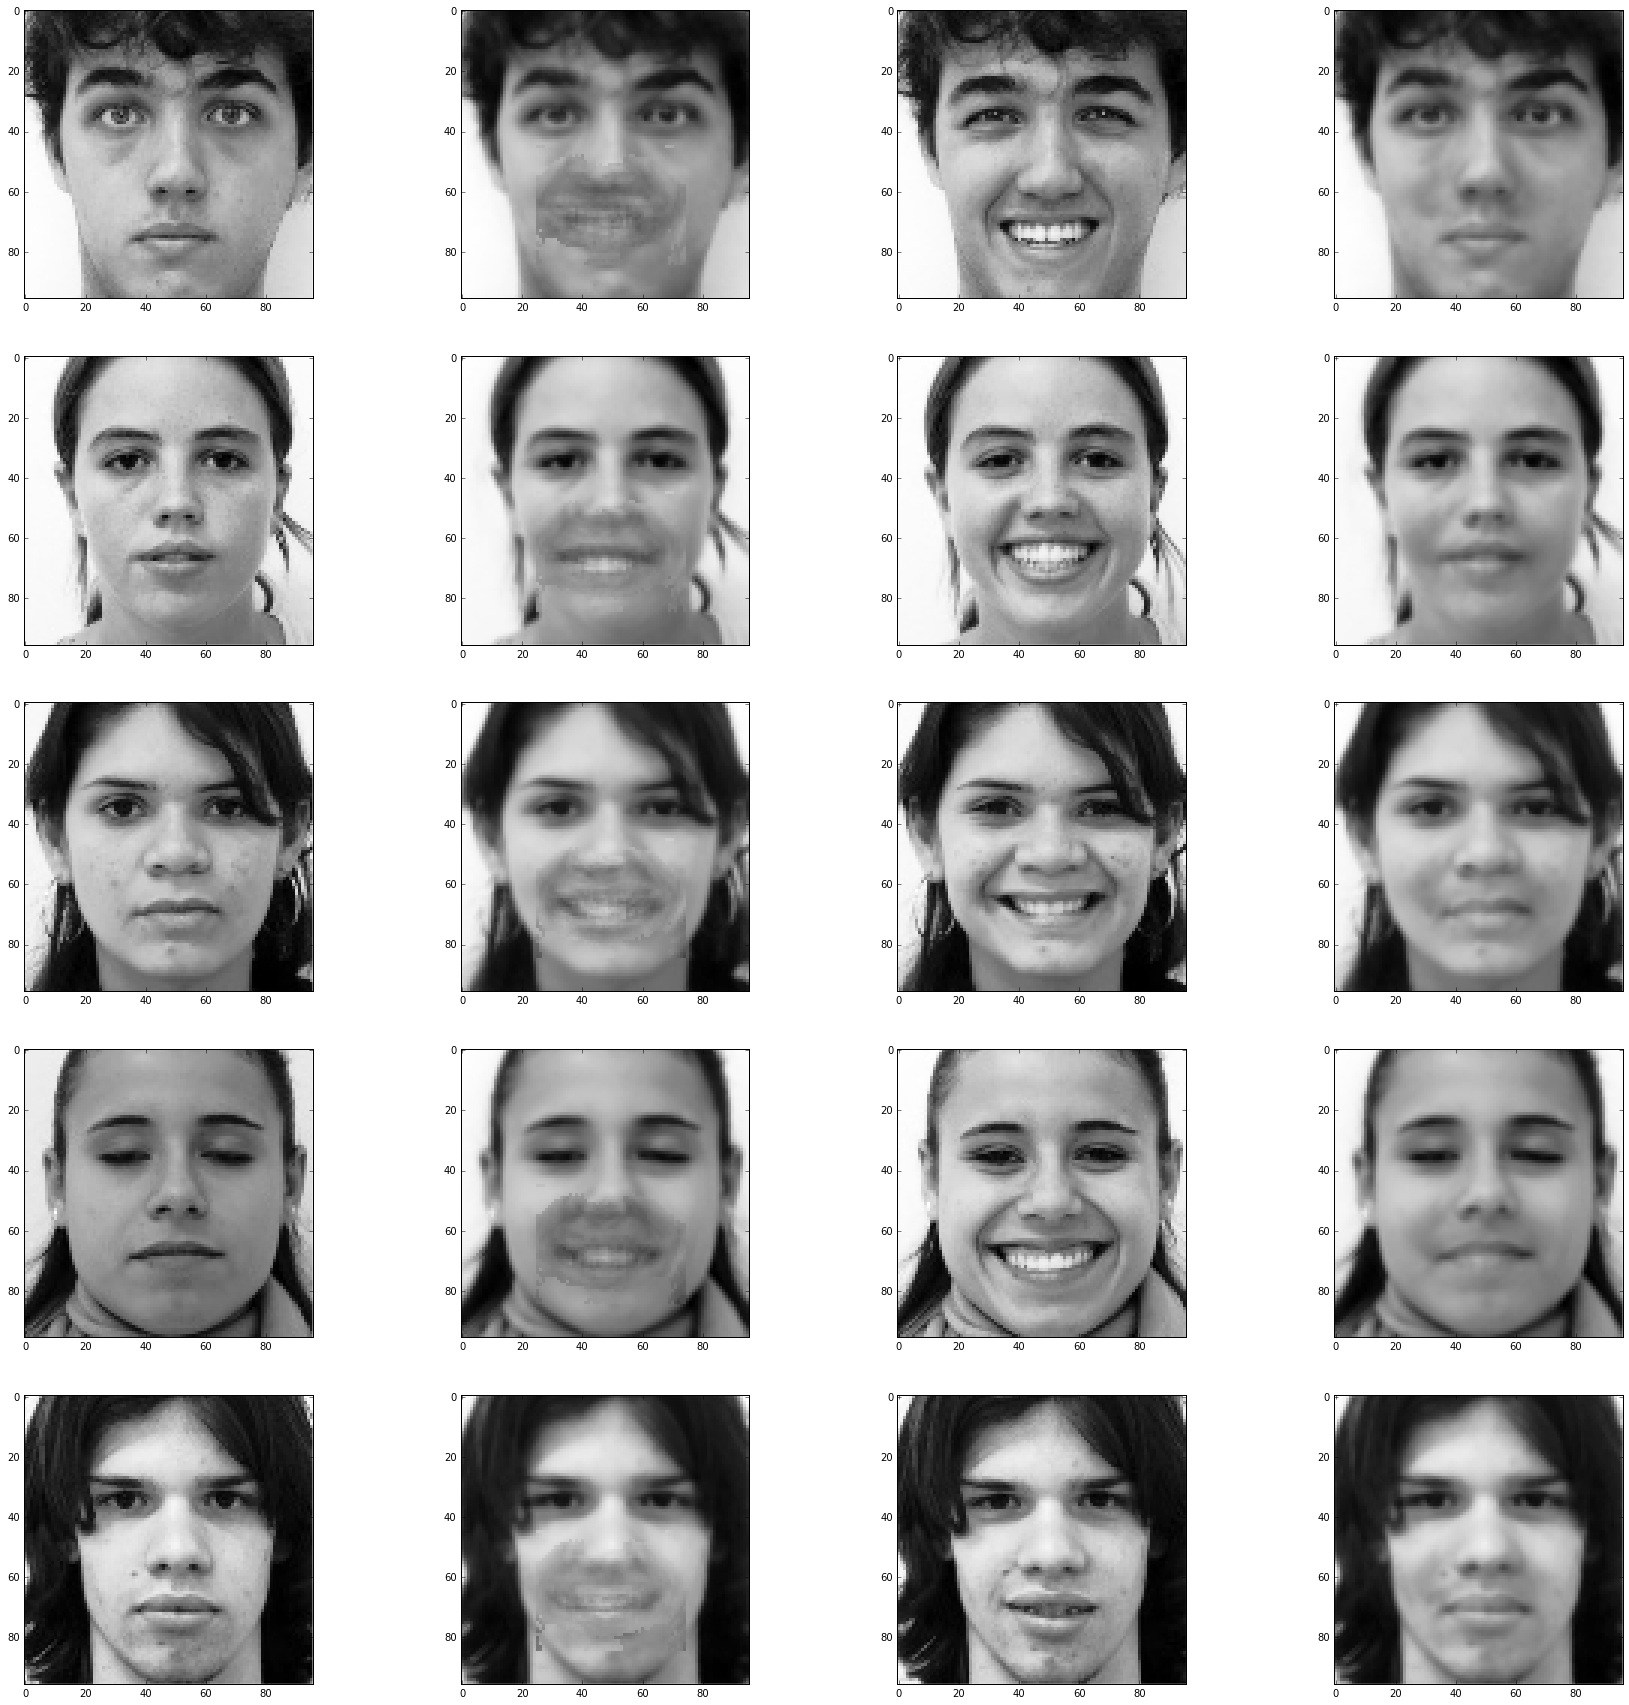

100.480080915 100.199216026


In [42]:
with Timer("Training Selection Aware"):
  sa = (SOAR(SelectionAware(selection=set(indices_selected)), batch_size=740, alpha=10)
        .fit(neutral_training, smiling_training))
  sap = (sa.predict(neutral_test))

with Timer("Training Selection Aware (w/o selection)"):
  sa2 = (SOAR(SelectionAware(), batch_size=740, alpha=10)
        .fit(neutral_training, smiling_training))
  sap2 = (sa2.predict(neutral_test))

plot_many(FACES_SHAPE, 4, neutral_test[:5], sap[:5], smiling_test[:5], sap2[:5])
print MSE(sap, smiling_test), MSE(sap2, smiling_test)

# MNIST

## Constants

In [22]:
MNIST_DIM = 784
MNIST_SHAPE = (28, 28)

MNIST_HDIM = 392
MNIST_HSHAPE = (28, 14)

MNIST_TRAINING = 'train-images-idx3-ubyte'
MNIST_TEST = 't10k-images-idx3-ubyte'

MNIST_SPLIT = 14
MNIST_REPEAT = 1
MNIST_DISTORTION = 0

## Load digits

In [23]:
def read_mnist(filename):
  with open(filename, 'rb') as f:
    magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
    return np.fromfile(f, dtype=np.uint8).astype(np.float_).reshape(num, rows, cols) / 255

mnist_training = read_mnist(MNIST_TRAINING)
mnist_test = read_mnist(MNIST_TEST)

## Split into input/output and training/testing

In [24]:
mnist_training_l = mnist_training[:,:,:MNIST_SPLIT].reshape(-1, MNIST_HDIM)
mnist_training_r = mnist_training[:,:,MNIST_SPLIT:].reshape(-1, MNIST_HDIM)

mnist_test_l = mnist_test[:,:,:MNIST_SPLIT].reshape(-1, MNIST_HDIM)
mnist_test_r = mnist_test[:,:,MNIST_SPLIT:].reshape(-1, MNIST_HDIM)

mnist_training = mnist_training.reshape(-1, MNIST_DIM)
mnist_test = mnist_test.reshape(-1, MNIST_DIM)

In [25]:
def mnist_join(left, right):
  return np.append(left.reshape(-1, *MNIST_HSHAPE), right.reshape(-1, *MNIST_HSHAPE),
                   axis=2).reshape(-1, MNIST_DIM)

## Ridge Regression

In [26]:
class MNIST_RidgeRegression:
  def __init__(self, beta=1):
    self.beta = beta
  def set_x(self, X1, X2):
    self.X1 = X1.T
    self.X2 = X2.T
    self.X = self.X1.T.dot(self.X2) + 1
  def set_y(self, Y1, Y2):
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    ks = []
    r = k / 14
    c = k % 14
    if c > 0: ks += [k - 1]
    if c < 13: ks += [k + 1]
    if r > 0: ks += [k - 14]
    if r < 27: ks += [k + 14]
    Ky = self.Y1[ks].T.dot(self.Y2[ks])
    if c == 0: Ky += np.outer(self.X1[k+13], self.X2[k+13])
    return (self.X + 1)**3 + self.beta * Ky

Started Training (dot + 1)**2 + beta
Iteration #0 d=60.4432516153
Finished Training (dot + 1)**2 + beta 4m 17s
Started Training (dot + 1)**2
Iteration #0 d=61.0535230709
Finished Training (dot + 1)**2 2m 51s


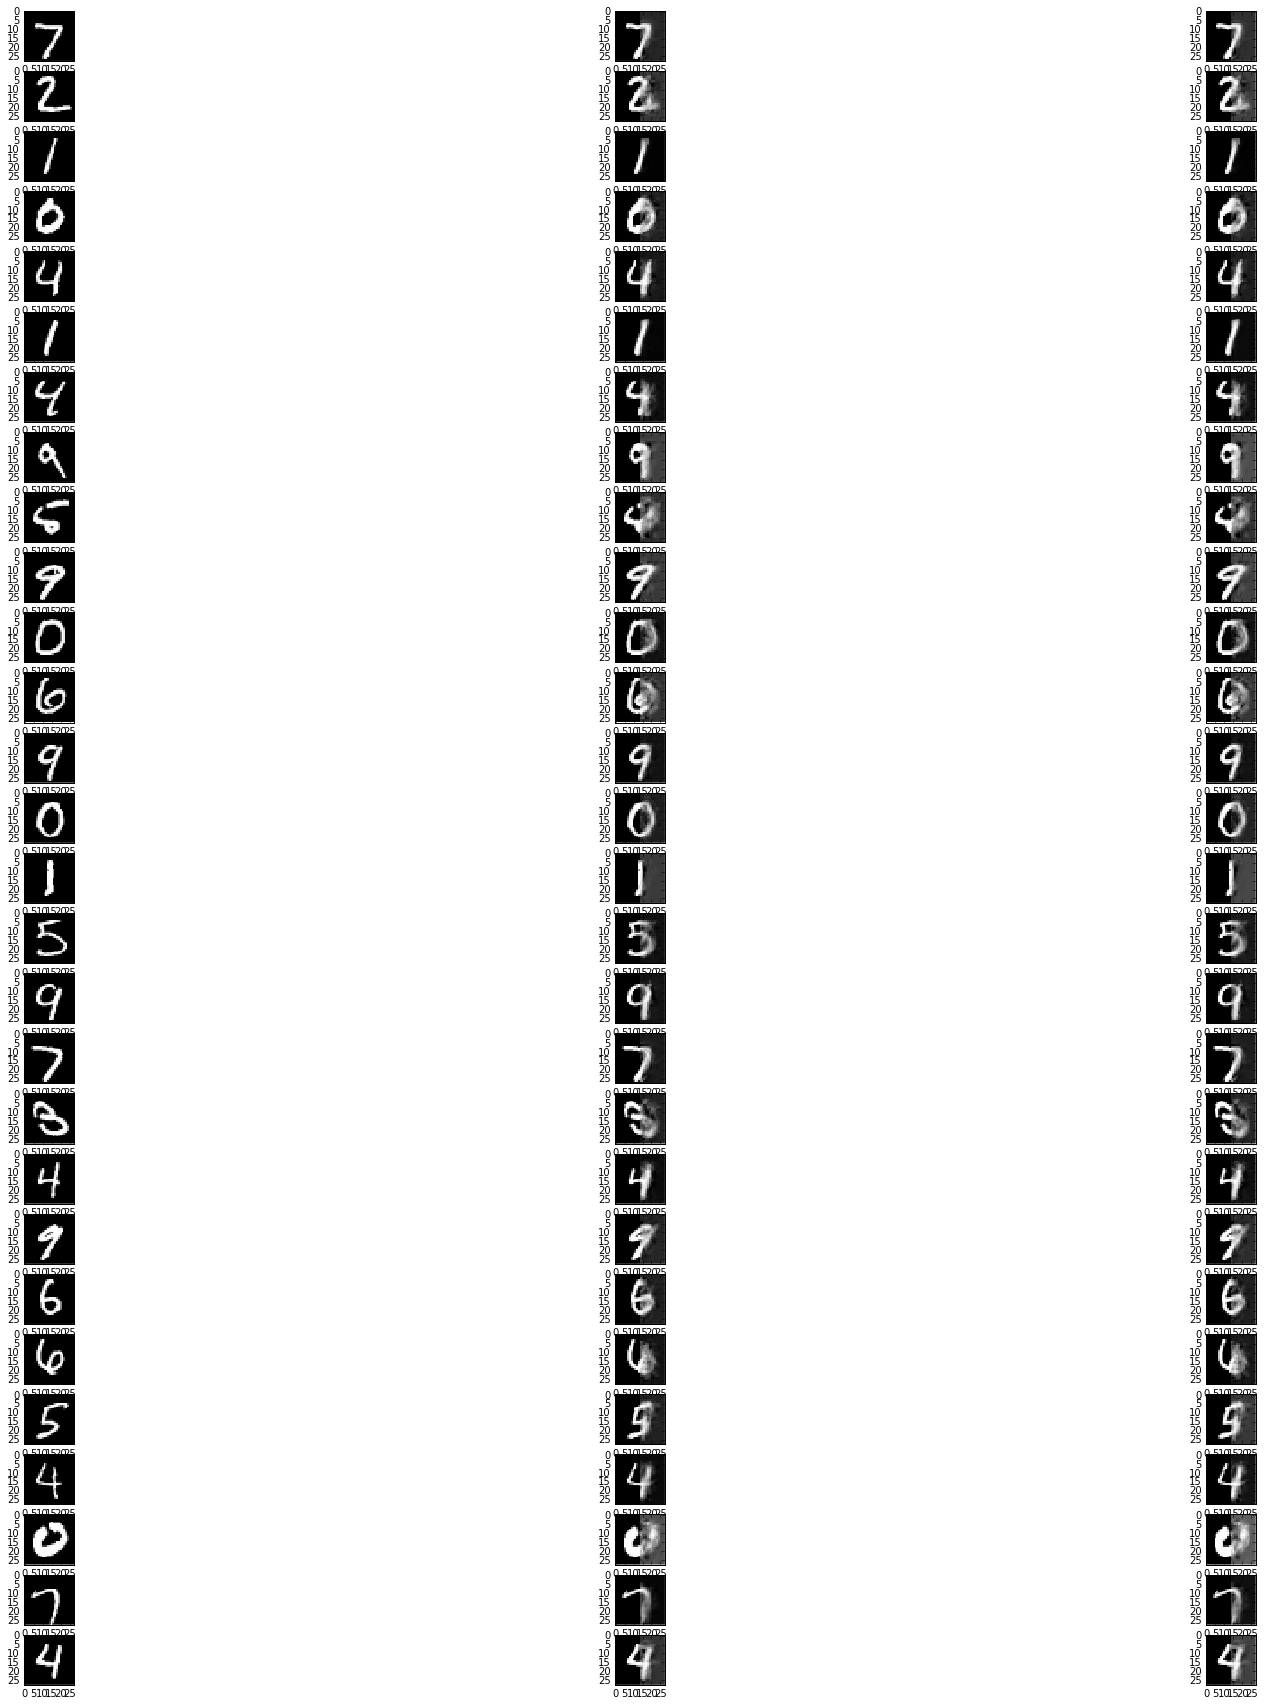

21.6935306459
23.0671001823


In [43]:
with Timer("Training (dot + 1)**2 + beta"):
  rr = (SOAR(MNIST_RidgeRegression(beta=10), batch_size=1000, alpha=100)
        .fit(mnist_training_l[:3000], mnist_training_r[:3000]))
  rr.verbose = 20
  rrp = rr.predict(mnist_test_l[:100])
  
with Timer("Training (dot + 1)**2"):
  rr2 = (SOAR(MNIST_RidgeRegression(beta=0), batch_size=1000, alpha=100)
        .fit(mnist_training_l[:3000], mnist_training_r[:3000]))
  rr2.verbose = 20
  rr2p = rr2.predict(mnist_test_l[:100])

rr_digits = mnist_join(mnist_test_l[:100], rrp)
rr2_digits = mnist_join(mnist_test_l[:100], rr2p)
  
plot_many(MNIST_SHAPE, 3, mnist_test[:28], rr_digits[:28], rr2_digits[:28])
print MSE(rrp, mnist_test_r[:100])
print MSE(rr2p, mnist_test_r[:100])

Iteration #0 d=54.4514744945


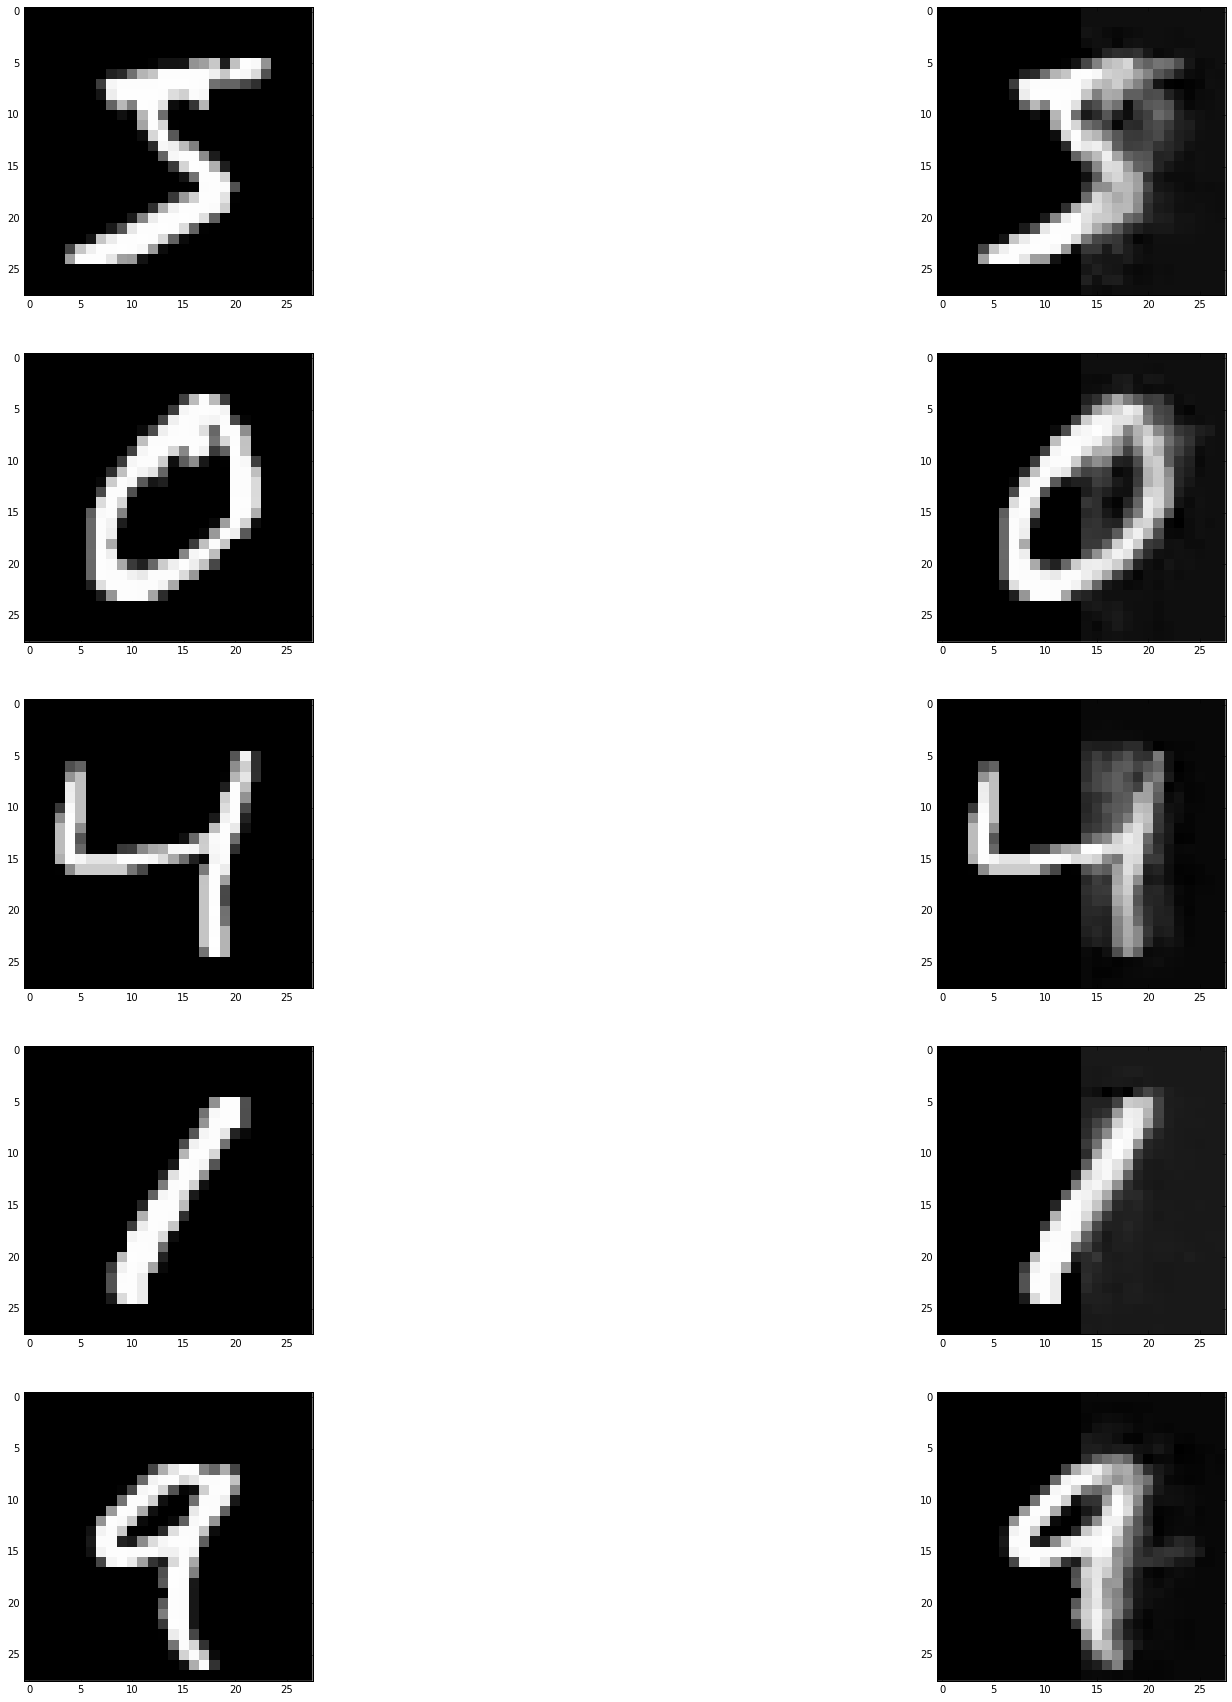

In [51]:
rrp_training = rr.predict(mnist_training_l[:5])
rr_digits_training = mnist_join(mnist_training_l[:5], rrp_training)
plot_many(MNIST_SHAPE, 2, mnist_training[:5], rr_digits_training)

In [ ]:
mnist_threshold = .35

rrp_threshold = rrp.copy()
rrp_threshold[rrp < mnist_threshold] = 0

rr_digits_threshold = rr_digits.copy()
rr_digits_threshold[rr_digits < mnist_threshold] = 0

plot_many(MNIST_SHAPE, 3, mnist_test[:28], rr_digits_threshold[:28], rr2_digits[:28])
print MSE(rrp_threshold, mnist_test_r[:100])
print MSE(rr2p, mnist_test_r[:100])

In [ ]:
rrp_training_threshold = rrp_training.copy()
rrp_training_threshold[rrp_training < mnist_threshold] = 0

rr_digits_training_threshold = rr_digits_training.copy()
rr_digits_training_threshold[rr_digits_training < mnist_threshold] = 0

plot_many(MNIST_SHAPE, 2, mnist_training[:5], rr_digits_training_threshold)